In [1]:
using Comrade #Import Comrade
using PythonPlot #Improt Python Plotting with Matplotlib

    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/Comrade/Id3Id/CondaPkg.toml
    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/PythonCall/dsECZ/CondaPkg.toml
    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [2]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [3]:
load_ehtim()

Python module: <module 'ehtim' from '/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/ehtim/__init__.py'>

In [4]:
obs = load_ehtim_uvfits(joinpath(dirname(pathof(Comrade)), "..", "examples", "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))
obs = scan_average(obs.flag_uvdist(uv_min=0.1e9))
typeof(obs)

[ Info: Before homogenizing we have 25 unique times
[ Info: After homogenizing we have 25 unique times


PythonCall.Py

In [5]:
dlcamp = extract_lcamp(obs)
dcphase = extract_cphase(obs)

/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragg

EHTObservation{Float64,Comrade.EHTClosurePhaseDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 141


In [6]:
function model(θ)
    (;radius, width, α, β, f, σG, τG, ξG, xG, yG) = θ
    ring = f*smoothed(stretched(MRing((α,), (β,)), radius, radius), width)
    g = (1-f)*shifted(rotated(stretched(Gaussian(), σG, σG*(1+τG)), ξG), xG, yG)
    return ring + g
end

model (generic function with 1 method)

In [7]:
lklhd = RadioLikelihood(model, dlcamp, dcphase)

RadioLikelihood
	Number of data products: 2


In [8]:
using Distributions
prior = (
        radius = Uniform(μas2rad(10.0), μas2rad(30.0)),
        width = Uniform(μas2rad(1.0), μas2rad(10.0)),
        α = Uniform(-0.5, 0.5),
        β = Uniform(-0.5, 0.5),
        f = Uniform(0.0, 1.0),
        σG = Uniform(μas2rad(1.0), μas2rad(40.0)),
        τG = Uniform(0.0, 0.75),
        ξG = Uniform(0.0, 1π),
        xG = Uniform(-μas2rad(80.0), μas2rad(80.0)),
        yG = Uniform(-μas2rad(80.0), μas2rad(80.0))
)

(radius = Uniform{Float64}(a=4.848136811095359e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.848136811095359e-11), α = Uniform{Float64}(a=-0.5, b=0.5), β = Uniform{Float64}(a=-0.5, b=0.5), f = Uniform{Float64}(a=0.0, b=1.0), σG = Uniform{Float64}(a=4.84813681109536e-12, b=1.9392547244381437e-10), τG = Uniform{Float64}(a=0.0, b=0.75), ξG = Uniform{Float64}(a=0.0, b=3.141592653589793), xG = Uniform{Float64}(a=-3.8785094488762873e-10, b=3.8785094488762873e-10), yG = Uniform{Float64}(a=-3.8785094488762873e-10, b=3.8785094488762873e-10))

In [9]:
post = Posterior(lklhd, prior)

Posterior{RadioLikelihood{typeof(model), Tuple{Comrade.ConditionedLikelihood{Comrade.var"#75#76"{Base.Fix2{typeof(logclosure_amplitudes), Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Table{NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Symbol, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}}, 1, NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Vector{Symbol}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}}},

In [10]:
logdensityof(post, (radius = μas2rad(20.0),
                  width = μas2rad(10.0),
                  α = 0.3,
                  β = 0.3,
                  f = 0.6,
                  σG = μas2rad(20.0),
                  τG = 0.1,
                  ξG = 0.5,
                  xG = 0.0,
                  yG = 0.0))

-35607.67528882893

In [11]:
cpost = ascube(post)

Comrade.TransformedPosterior{Posterior{RadioLikelihood{typeof(model), Tuple{Comrade.ConditionedLikelihood{Comrade.var"#75#76"{Base.Fix2{typeof(logclosure_amplitudes), Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Table{NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Symbol, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}}, 1, NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Vector{Symbol}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{

In [12]:
fpost = asflat(post)

Comrade.TransformedPosterior{Posterior{RadioLikelihood{typeof(model), Tuple{Comrade.ConditionedLikelihood{Comrade.var"#75#76"{Base.Fix2{typeof(logclosure_amplitudes), Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Table{NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Symbol, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}}, 1, NamedTuple{(:sites, :X, :Y, :Z, :SEFD1, :SEFD2, :fr_parallactic, :fr_elevation, :fr_offset), Tuple{Vector{Symbol}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{

In [13]:
logdensityof(cpost, rand(rng, dimension(cpost)))
logdensityof(fpost, randn(rng, dimension(fpost)))

-21458.45672493566

In [14]:
#, we will use `cpost` since it restricts the domain to live within the compact unit hypercube
#, which is easier to explore for non-gradient-based optimizers like `BBO`.
import Pkg; Pkg.add("OptimizationBBO")
using ComradeOptimization
using OptimizationBBO

ndim = dimension(cpost)
f = OptimizationFunction(cpost)
prob = Optimization.OptimizationProblem(f, randn(rng, ndim), nothing, lb=fill(0.0, ndim), ub=fill(1.0, ndim))

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/ComradeTutorial/Project.toml`
  No Changes to `~/Documents/ComradeTutorial/Manifest.toml`


OptimizationProblem. In-place: true
u0: 10-element Vector{Float64}:
  2.085484020168047
 -1.8006478341672416
  0.48256987064117174
 -0.5700747606274734
 -0.6651223484513427
  2.243383997718311
 -1.4640881413373288
 -1.0124378829910503
 -2.042002086038424
 -0.7870208631180695

In [15]:
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=5_00)

u: 10-element Vector{Float64}:
 0.5521569991979527
 0.1562805809923409
 0.14775281474140528
 0.41942275830846587
 0.8120701835504518
 0.2784183258889149
 0.6308330896646794
 0.3937329494260041
 0.32421678482510513
 0.48499581456887286

In [16]:
xopt = transform(cpost, sol)

(radius = 1.020200215772645e-10, width = 1.1667163549210399e-11, α = -0.3522471852585947, β = -0.08057724169153413, f = 0.8120701835504518, σG = 5.749073206149346e-11, τG = 0.4731248172485096, ξG = 1.2369485413929762, xG = -1.3635537220193668e-10, yG = -1.1638774993463718e-11)

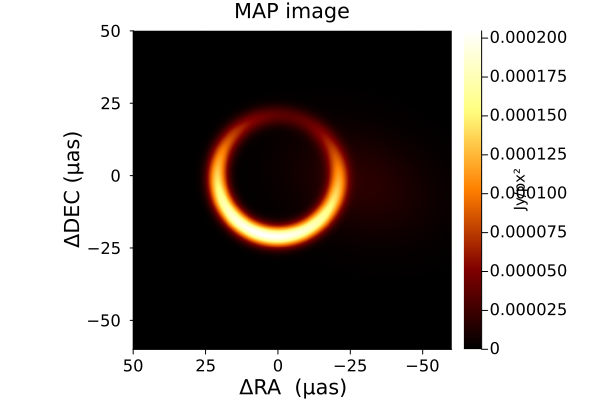

In [17]:
using Plots
Plots.plot(model(xopt), title="MAP image", xlims=(-60.0,50.0), ylims=(-60.0,50.0))

In [18]:
using ComradeAHMC, ForwardDiff
chain, stats = sample(rng, post, AHMC(metric=DiagEuclideanMetric(ndim), autodiff=Val(:ForwardDiff)), 2000; nadapts=1000, init_params=xopt)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:01:01
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.01
  n_steps:                                      63
  is_accept:                                    true
  acceptance_rate:                              0.9316659785341027
  log_density:                                  -239.56111786942813
  hamiltonian_energy:                           243.17630985525895
  hamiltonian_energy_error:                     -0.010811227237041976
  max_ham

(NamedTuple{(:radius, :width, :α, :β, :f, :σG, :τG, :ξG, :xG, :yG), NTuple{10, Float64}}[(radius = 1.0203154347448051e-10, width = 1.1689488646831854e-11, α = -0.3513807701598185, β = -0.08173591022833393, f = 0.8120470124843362, σG = 5.7653340630260346e-11, τG = 0.4740955062135316, ξG = 1.2352810466624686, xG = -1.3712368314039382e-10, yG = -1.1903901450911996e-11), (radius = 1.0177603721599868e-10, width = 1.1760740339601948e-11, α = -0.35200852445963493, β = -0.09014374609347575, f = 0.8149035025721301, σG = 5.833717808324022e-11, τG = 0.47516881433171865, ξG = 1.2448913006500701, xG = -1.383611021435523e-10, yG = -1.1875955079114029e-11), (radius = 1.0186171610069522e-10, width = 1.1688652615236471e-11, α = -0.3498322971490688, β = -0.10611910127050822, f = 0.8156831865723485, σG = 6.01872993312666e-11, τG = 0.482148515578932, ξG = 1.243369946309624, xG = -1.4112112201992e-10, yG = -1.4940984001088797e-11), (radius = 1.0216120007162286e-10, width = 1.1813008644405061e-11, α = -0.34

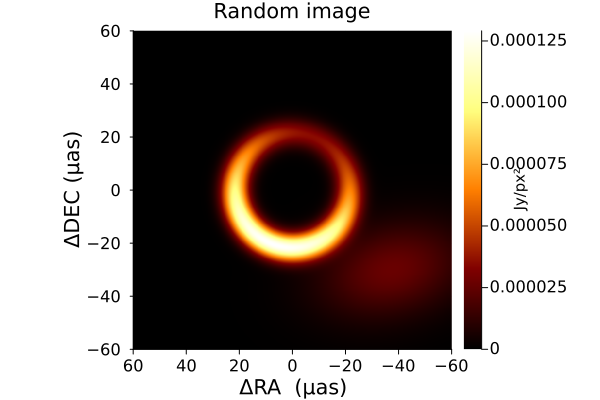

In [19]:
Plots.plot(model(chain[end]), title="Random image", xlims=(-60.0,60.0), ylims=(-60.0,60.0))

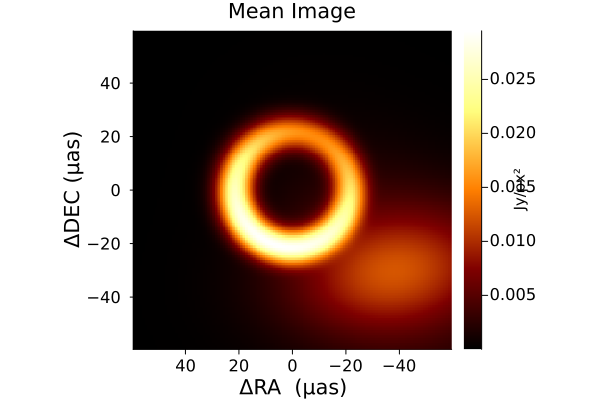

In [20]:
meanimg = mean(intensitymap.(model.(sample(chain[1000:end], 100)), μas2rad(120.0), μas2rad(120.0), 128, 128))
Plots.plot(sqrt.(max.(meanimg, 0.0)), title="Mean Image") #plot on a sqrt color scale to see the Gaussian

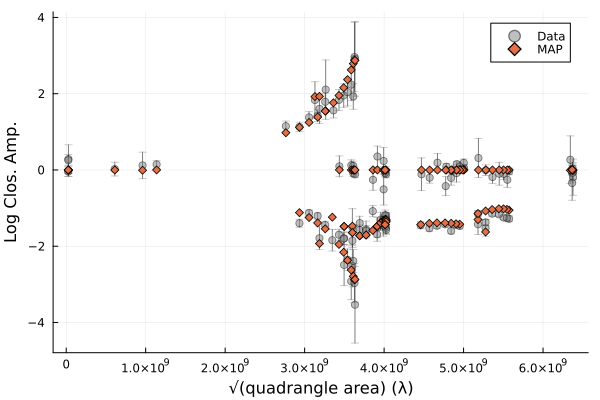

In [21]:
Plots.plot(model(xopt), dlcamp, label="MAP")